In [227]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms, models
import ochumanApi.ochuman as ochuman


from sklearn.cluster import KMeans
from scipy.optimize import minimize

# from torchvision.transforms.functional import affine
import random
from PIL import Image



print(torch.cuda.is_available())
print(torch.version.cuda)

device = "mps" if torch.backends.mps.is_built() else "cpu"
print(f"Using device: {device}")

False
None
Using device: mps


In [228]:
def cluster_pose_templates(poses, num_clusters=3):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(poses)
    pose_templates = kmeans.cluster_centers_
    return pose_templates

def error_function(H, P, P_mu):
    transformed_pose = np.dot(H, P.T).T
    error = np.linalg.norm(transformed_pose - P_mu)
    return error

def estimate_affine_transform(P, pose_templates):
    best_H = None
    best_error = float('inf')
    for P_mu in pose_templates:
        result = minimize(lambda x: error_function(x.reshape(2, 3), P, P_mu), np.zeros(6))
        if result.fun < best_error:
            best_error = result.fun
            best_H = result.x.reshape(2, 3)
    return best_H


In [229]:
class OCHumanDataset(Dataset):
    def __init__(self, img_dir, annFile, transform_params=None):
        self.img_dir = img_dir
        self.ochuman = ochuman.OCHuman(annFile)
        self.transform_params = transform_params
        # self.transforms = transforms.Compose([transforms.Resize((256, 256)), 
        #                                       transforms.Lambda(lambda x: x[[2, 0, 1]]), 
        #                                       transforms.ToTensor(), 
        #                                     #   transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        #                                     ])

    def __len__(self):
        return len(self.ochuman.getImgIds())

    def __getitem__(self, idx):
        img_id = self.ochuman.getImgIds()[idx]
        img = self.ochuman.visImg(self.img_dir, img_id)
        img = self.ochuman.visImg(self.img_dir, img_id)
        img = cv2.resize(img, (256, 256))

        if self.transform_params:
            img = self.apply_affine_transform(img)
            
        img = img.transpose((2, 0, 1))
        img = torch.from_numpy(img)
        img = img.float()
        img = img / 255.0
        # img = img - 0.5
        # img = img / 0.5
        img = img.unsqueeze(0)
        # print (img.shape)
        return img
    def apply_affine_transform(self, img):
        angle, translate, scale, shear = self.transform_params
        M = cv2.getRotationMatrix2D((img.shape[1] / 2, img.shape[0] / 2), angle, scale)
        img = cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
        return img



class OCHumanDataModule(pl.LightningDataModule):
    def __init__(self, img_dir, annFile, batch_size=32, transform_params=None):
        super().__init__()
        self.img_dir = img_dir
        self.annFile = annFile
        self.batch_size = batch_size
        self.transform_params = transform_params


    def setup(self, stage=None):
        self.dataset = OCHumanDataset(self.img_dir, self.annFile, self.transform_params)

    def train_dataloader(self):
        return DataLoader(self.dataset, batch_size=self.batch_size)

    # def val_dataloader(self):
        # return DataLoader(self.dataset, batch_size=self.batch_size)

    # def test_dataloader(self):
        # return DataLoader(self.dataset, batch_size=self.batch_size)
        
    def show_sample_images(self):
        fig, axs = plt.subplots(1, self.batch_size, figsize=(10, 10))
        examples = next(iter(self.train_dataloader()))
        for idx, img in enumerate(examples):
            img = img.squeeze().numpy().astype(np.float64)
            img = img.transpose((1, 2, 0))
            axs[idx].imshow(img[:,:,::-1])
            axs[idx].axis('off')
        plt.show()

In [230]:
ANNO_FILE='../data/ochuman/annotations/ochuman.json'
IMG_DIR = '../data/ochuman/images'
BATCH_SIZE = 5

In [231]:
angle = random.randint(-50, 50)  
translation = (random.randint(-20, 20), random.randint(-20, 10))  
scale = random.uniform(0.9, 1.1)  
shear = random.randint(-10, 10) 

transform_params = (angle, translation, scale, shear)

In [ ]:
data_module = OCHumanDataModule(IMG_DIR, ANNO_FILE, BATCH_SIZE, transform_params)
data_module.setup()


In [ ]:
train_DataLoader = data_module.train_dataloader()
example = next(iter(train_DataLoader))
print(example.shape)

torch.Size([5, 1, 3, 256, 256])


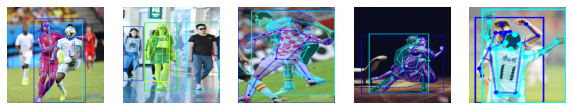

In [ ]:
data_module.show_sample_images()